<a href="https://colab.research.google.com/github/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Importa%C3%A7%C3%A3o_e_Limpeza_dos_dados_de_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
def import_and_clean_data(url_data):
  return

In [3]:
import pandas as pd
raw_data = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Covid_per_state.csv')
raw_data.head()

,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
0,202151,2021-12-20,644,AC,NaN,12,state,88335,9875.68057,0,1850,0,0.0209,894470,False,True
1,202151,2021-12-20,653,AL,NaN,27,state,241901,7217.60097,6,6379,2,0.0264,3351543,True,False
2,202151,2021-12-20,648,AM,NaN,13,state,432712,10283.77879,47,13820,0,0.0319,4207714,True,False
3,202151,2021-12-20,641,AP,NaN,16,state,126200,14644.22766,60,2009,1,0.0159,861773,True,False
4,202151,2021-12-20,655,BA,NaN,29,state,1264804,8471.20089,0,27438,6,0.0217,14930634,True,False


Copiando a tabela do site em formato html

In [4]:
html_metadata = """<table>
<thead>
<tr>
<th>Coluna</th>
<th>Tipo</th>
<th>Título</th>
<th>Descrição</th>
</tr>
</thead>
<tbody>
<tr>
<td> epidemiological_week </td>
<td> integer</td>
<td> Semana epidemiológica </td>
<td> Número da semana epidemiológica. </td>
</tr>
<tr>
<td> date </td>
<td> string (max_length=10)</td>
<td> Data </td>
<td> Data de coleta dos dados no formato YYYY-MM-DD. </td>
</tr>
<tr>
<td> order_for_place </td>
<td> integer</td>
<td> Dias a partir do 1o caso </td>
<td> Número que identifica a ordem do registro para este local. O registro referente ao primeiro boletim em que esse local aparecer será contabilizado como 1 e os demais boletins incrementarão esse valor. </td>
</tr>
<tr>
<td> state </td>
<td> string (max_length=2)</td>
<td> UF </td>
<td> Sigla da unidade federativa, exemplo: SP. </td>
</tr>
<tr>
<td> city </td>
<td> string (max_length=64)</td>
<td> Município </td>
<td> Nome do município (pode estar em branco quando o registro é referente ao estado, pode ser preenchido com `Importados/Indefinidos` também). </td>
</tr>
<tr>
<td> city_ibge_code </td>
<td> integer</td>
<td> Cód. IBGE </td>
<td> Código IBGE do local. </td>
</tr>
<tr>
<td> place_type </td>
<td> string (max_length=5)</td>
<td> Tipo de local </td>
<td> Tipo de local que esse registro descreve, pode ser city ou state. </td>
</tr>
<tr>
<td> last_available_date </td>
<td> string (max_length=10)</td>
<td> Data da informação </td>
<td> Data da qual o dado se refere. </td>
</tr>
<tr>
<td> last_available_confirmed </td>
<td> integer</td>
<td> Confirmados acum. </td>
<td> Número de casos confirmados do último dia disponível igual ou anterior à data date. </td>
</tr>
<tr>
<td> last_available_confirmed_per_100k_inhabitants </td>
<td> float</td>
<td> Confirmados acum./100k hab. </td>
<td> Número de casos confirmados por 100.000 habitantes do último dia disponível igual ou anterior à data date. </td>
</tr>
<tr>
<td> new_confirmed </td>
<td> integer</td>
<td> Confirmações no dia </td>
 <td> Número de novos casos confirmados desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro). </td>
</tr>
<tr>
<td> last_available_deaths </td>
<td> integer</td>
<td> Óbitos acum. </td>
<td> Número de mortes do último dia disponível igual ou anterior à data date. </td>
</tr>
<tr>
<td> new_deaths </td>
<td> integer</td>
<td> Óbitos no dia </td>
<td> Número de novos óbitos desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro). </td>
</tr>
<tr>
<td> last_available_death_rate </td>
<td> float</td>
<td> Óbitos/confirmados </td>
<td> Taxa de mortalidade (mortes / confirmados) do último dia disponível igual ou anterior à data date. </td>
</tr>
<tr>
<td> estimated_population </td>
<td> integer</td>
<td> População estimada 2019 </td>
<td> População estimada para o local em 2020, segundo o IBGE. </td>
</tr>
<tr>
<td> estimated_population_2019 </td>
<td> integer</td>
<td> População estimada 2019 </td>
<td> População estimada para esse município/estado em 2019, segundo o IBGE. </td>
</tr>
<tr>
<td> is_last </td>
<td> bool</td>
<td> É a última atualização? </td>
<td> Campo pré-computado que diz se esse registro é o mais novo para esse local, pode ser True ou False (caso filtre por esse campo, use is_last=True ou is_last=False, não use o valor em minúsculas). </td>
</tr>
<tr>
<td> is_repeated </td>
<td> bool</td>
<td> Dado repetido? </td>
<td> Campo pré-computado que diz se as informações nesse registro foram publicadas pela Secretaria Estadual de Saúde no dia date ou se o dado é repetido do último dia em que o dado está disponível (igual ou anterior a date). Isso ocorre pois nem todas as secretarias publicam boletins todos os dias. Veja também o campo last_available_date. </td>
</tr>
</tbody>
</table>"""

In [5]:
metadata = pd.read_html(html_metadata)[0]
metadata

,Coluna,Tipo,Título,Descrição
0,epidemiological_week,integer,Semana epidemiológica,Número da semana epidemiológica.
1,date,string (max_length=10),Data,Data de coleta dos dados no formato YYYY-MM-DD.
2,order_for_place,integer,Dias a partir do 1o caso,Número que identifica a ordem do registro para...
3,state,string (max_length=2),UF,"Sigla da unidade federativa, exemplo: SP."
4,city,string (max_length=64),Município,Nome do município (pode estar em branco quando...
5,city_ibge_code,integer,Cód. IBGE,Código IBGE do local.
6,place_type,string (max_length=5),Tipo de local,"Tipo de local que esse registro descreve, pode..."
7,last_available_date,string (max_length=10),Data da informação,Data da qual o dado se refere.
8,last_available_confirmed,integer,Confirmados acum.,Número de casos confirmados do último dia disp...
9,last_available_confirmed_per_100k_inhabitants,float,Confirmados acum./100k hab.,Número de casos confirmados por 100.000 habita...


In [6]:
raw_data.shape

(17500, 16)

In [7]:
filter_columns = ['epidemiological_week', 'date', 'state', 'last_available_confirmed', 'new_confirmed', 'last_available_deaths', 'new_deaths']

In [8]:
data = raw_data[filter_columns]
data.head()

,epidemiological_week,date,state,last_available_confirmed,new_confirmed,last_available_deaths,new_deaths
0,202151,2021-12-20,AC,88335,0,1850,0
1,202151,2021-12-20,AL,241901,6,6379,2
2,202151,2021-12-20,AM,432712,47,13820,0
3,202151,2021-12-20,AP,126200,60,2009,1
4,202151,2021-12-20,BA,1264804,0,27438,6


In [9]:
data_new_confirmed = data.pivot_table(index=['date'], columns=['state'], values=['new_confirmed'])
data_new_confirmed.columns = data_new_confirmed.columns.droplevel()
data_new_confirmed

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,8.0,14.0,179.0,110.0,0.0,121.0,30.0,270.0,0.0,234.0,401.0,0.0,152.0,799.0,0.0,18.0,45.0,585.0,5.0,137.0,265.0,7.0,163.0,109.0,9.0,0.0,0.0
2021-12-17,6.0,15.0,319.0,104.0,0.0,212.0,39.0,311.0,0.0,386.0,393.0,0.0,149.0,865.0,0.0,13.0,0.0,501.0,0.0,92.0,327.0,5.0,215.0,164.0,11.0,490.0,0.0
2021-12-18,15.0,17.0,87.0,72.0,0.0,106.0,0.0,173.0,0.0,416.0,176.0,0.0,64.0,138.0,34.0,7.0,145.0,410.0,30.0,0.0,100.0,0.0,151.0,137.0,1.0,102.0,0.0


In [10]:
data_new_confirmed.corr()['SP'].sort_values(ascending=False)

state
SP    1.000000
MG    0.814720
BA    0.800318
PE    0.782539
MT    0.699265
PI    0.643634
MS    0.638606
ES    0.614583
AL    0.595365
TO    0.586870
RO    0.586498
PB    0.583113
RS    0.542452
SE    0.530664
AC    0.499829
CE    0.490710
PR    0.488767
SC    0.478441
MA    0.466676
PA    0.462104
AM    0.449511
GO    0.419069
DF    0.412111
RR    0.393433
AP    0.301913
RN    0.225675
RJ    0.202690
Name: SP, dtype: float64

In [11]:
data_new_confirmed.corr()

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
state,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC,1.000000,0.500887,0.606974,0.509719,0.569722,0.411573,0.428895,0.527383,0.176917,0.434728,0.460170,0.386880,0.445055,0.537436,0.402369,0.445460,0.506307,0.256062,0.073654,0.053683,0.593621,0.342166,0.323852,0.382507,0.439940,0.499829,0.441347
AL,0.500887,1.000000,0.381201,0.457668,0.653985,0.489046,0.626139,0.487418,0.192133,0.588744,0.508376,0.470235,0.465531,0.548313,0.599325,0.581954,0.581736,0.316332,0.113592,0.229201,0.514468,0.390701,0.267857,0.261177,0.661668,0.595365,0.506761
AM,0.606974,0.381201,1.000000,0.426983,0.526169,0.225536,0.252506,0.415306,0.124800,0.356668,0.383184,0.285558,0.344332,0.484314,0.328430,0.398567,0.344414,0.218385,0.091014,0.070243,0.536715,0.283538,0.253646,0.301946,0.339933,0.449511,0.281113
AP,0.509719,0.457668,0.426983,1.000000,0.341988,0.320285,0.342223,0.448967,0.117380,0.446647,0.213664,0.284471,0.283538,0.592622,0.310326,0.284335,0.400258,0.139458,0.050916,0.078963,0.442752,0.394113,0.170833,0.246602,0.353565,0.301913,0.315745
BA,0.569722,0.653985,0.526169,0.341988,1.000000,0.499293,0.501821,0.654222,0.390595,0.445412,0.751988,0.687097,0.672297,0.498662,0.619102,0.778688,0.708535,0.513024,0.164937,0.232760,0.674940,0.463743,0.517890,0.562688,0.638056,0.800318,0.628734
CE,0.411573,0.489046,0.225536,0.320285,0.499293,1.000000,0.316732,0.457899,0.209262,0.365897,0.442749,0.466043,0.446712,0.415445,0.430213,0.493825,0.502309,0.281116,0.114731,0.142001,0.427046,0.263825,0.274269,0.255148,0.476731,0.490710,0.415232
DF,0.428895,0.626139,0.252506,0.342223,0.501821,0.316732,1.000000,0.504958,0.367882,0.462457,0.330091,0.393444,0.509008,0.497033,0.378097,0.304076,0.586664,0.181743,0.087418,0.094985,0.431638,0.385749,0.190191,0.281861,0.472217,0.412111,0.587795
ES,0.527383,0.487418,0.415306,0.448967,0.654222,0.457899,0.504958,1.000000,0.436829,0.306276,0.629222,0.709494,0.668356,0.590189,0.435160,0.579697,0.685054,0.441065,0.160389,0.194705,0.635023,0.330073,0.424189,0.559139,0.584342,0.614583,0.569098
GO,0.176917,0.192133,0.124800,0.117380,0.390595,0.209262,0.367882,0.436829,1.000000,0.275308,0.385926,0.519459,0.741900,0.456591,0.257120,0.325195,0.580238,0.276913,0.115313,0.135345,0.476114,0.300186,0.273182,0.360104,0.204832,0.419069,0.675237


In [12]:
data_new_deaths = data.pivot_table(index=['date'], columns=['state'], values=['new_deaths'])
data_new_deaths.columns = data_new_deaths.columns.droplevel()
data_new_deaths

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,0.0,2.0,3.0,0.0,4.0,4.0,3.0,2.0,0.0,2.0,24.0,0.0,2.0,12.0,0.0,6.0,2.0,4.0,5.0,7.0,4.0,2.0,17.0,9.0,0.0,0.0,0.0
2021-12-17,0.0,2.0,0.0,0.0,7.0,0.0,7.0,13.0,0.0,3.0,19.0,0.0,5.0,6.0,0.0,10.0,6.0,1.0,0.0,2.0,2.0,0.0,12.0,10.0,0.0,259.0,0.0
2021-12-18,0.0,1.0,0.0,0.0,2.0,7.0,0.0,1.0,0.0,2.0,17.0,0.0,0.0,1.0,7.0,5.0,0.0,2.0,30.0,0.0,2.0,0.0,5.0,4.0,1.0,51.0,0.0


In [13]:
data_new_deaths.corr()['SP'].sort_values(ascending=False)

state
SP    1.000000
RS    0.781816
RJ    0.759054
PR    0.748741
BA    0.741463
SC    0.705246
TO    0.687274
MS    0.668002
MG    0.656719
PB    0.653186
AL    0.643569
MA    0.642422
SE    0.608074
PE    0.605668
DF    0.603580
MT    0.597697
RO    0.587958
ES    0.558924
CE    0.544051
GO    0.523769
PI    0.506530
AP    0.474616
PA    0.466781
AC    0.452326
RN    0.340118
RR    0.276803
AM    0.118246
Name: SP, dtype: float64

In [14]:
data_new_deaths.corr()

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
state,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC,1.000000,0.638973,0.246388,0.543843,0.569739,0.492103,0.510404,0.603460,0.365010,0.640611,0.334853,0.398723,0.554219,0.571454,0.596218,0.535790,0.491850,0.356153,0.400004,0.496982,0.574700,0.361336,0.490375,0.479193,0.586714,0.452326,0.465684
AL,0.638973,1.000000,0.140353,0.618418,0.763017,0.582855,0.569831,0.652146,0.452957,0.899775,0.544183,0.625499,0.691522,0.649307,0.771517,0.759754,0.620216,0.510380,0.547067,0.575370,0.591522,0.347984,0.520158,0.527183,0.801634,0.643569,0.645683
AM,0.246388,0.140353,1.000000,0.259393,0.132183,0.119827,-0.035850,0.161617,0.045972,0.089881,0.098486,0.053616,0.101212,0.245485,0.115985,0.165078,0.046299,0.047216,0.231469,0.060561,0.317995,0.269849,0.124654,0.128483,0.069448,0.118246,0.044431
AP,0.543843,0.618418,0.259393,1.000000,0.495120,0.523309,0.472173,0.680883,0.399390,0.636131,0.271877,0.438523,0.540949,0.572838,0.558050,0.601371,0.486554,0.355600,0.469142,0.401463,0.552101,0.333113,0.454413,0.448529,0.559982,0.474616,0.424606
BA,0.569739,0.763017,0.132183,0.495120,1.000000,0.478034,0.695387,0.621955,0.628546,0.719563,0.695209,0.788708,0.784034,0.462793,0.822977,0.524078,0.656119,0.693073,0.506923,0.515505,0.736260,0.338075,0.772762,0.776660,0.752224,0.741463,0.791924
CE,0.492103,0.582855,0.119827,0.523309,0.478034,1.000000,0.423661,0.526564,0.313312,0.624657,0.317287,0.390438,0.411311,0.619273,0.524306,0.587877,0.385491,0.387634,0.515347,0.356632,0.442783,0.294064,0.467342,0.397142,0.514016,0.544051,0.423166
DF,0.510404,0.569831,-0.035850,0.472173,0.695387,0.423661,1.000000,0.687831,0.641991,0.552932,0.508030,0.610680,0.793785,0.360475,0.696185,0.363745,0.597813,0.522755,0.416137,0.447036,0.612542,0.286409,0.649220,0.654780,0.645495,0.603580,0.731633
ES,0.603460,0.652146,0.161617,0.680883,0.621955,0.526564,0.687831,1.000000,0.565652,0.635766,0.395678,0.611219,0.720772,0.565339,0.635696,0.481205,0.585311,0.477118,0.486265,0.517738,0.676714,0.378675,0.578670,0.630212,0.681469,0.558924,0.559624
GO,0.365010,0.452957,0.045972,0.399390,0.628546,0.313312,0.641991,0.565652,1.000000,0.432085,0.407130,0.603295,0.696700,0.307014,0.562398,0.239183,0.469396,0.539262,0.342997,0.324092,0.607634,0.343191,0.594630,0.607471,0.460715,0.523769,0.655056


# Modelos Prophet

In [18]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Objetivo do modelo é prever 30 dias no futuro

In [15]:
estado = 'SC'

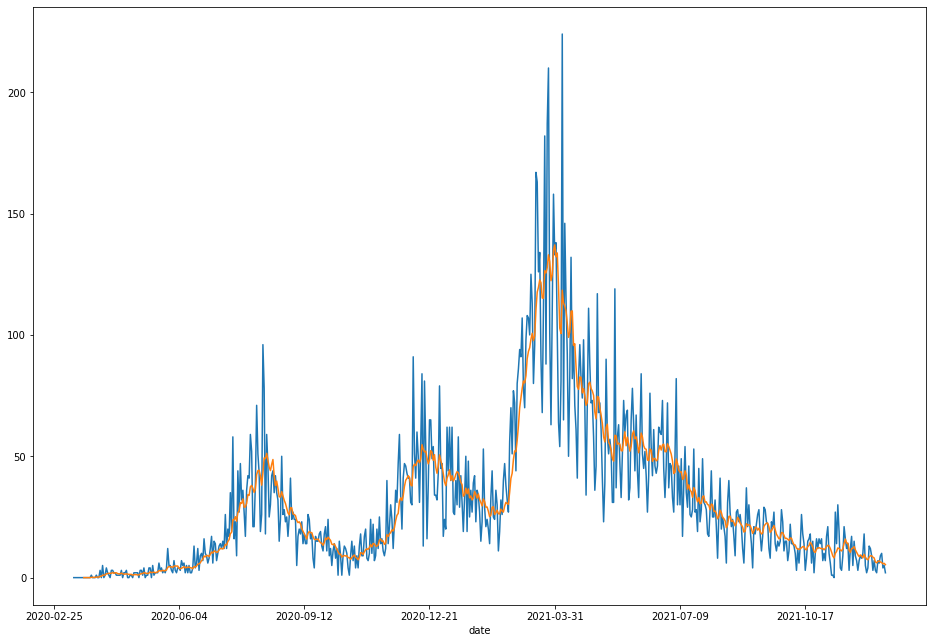

In [16]:
data_new_deaths[estado].plot(figsize=(16,11))
data_new_deaths[estado].rolling(window=9, center=False).mean().plot(figsize=(16,11))

Podemos ver claramente 3 ondas

In [17]:
data_new_deaths[estado].describe()

count    649.000000
mean      31.018490
std       32.198453
min        0.000000
25%        9.000000
50%       21.000000
75%       43.000000
max      224.000000
Name: SC, dtype: float64

## Modelo básico Prophet

In [19]:
df = pd.DataFrame()
df['ds'] = data_new_deaths.index
df['y'] = data_new_deaths[estado].values

In [20]:
modelo = Prophet()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


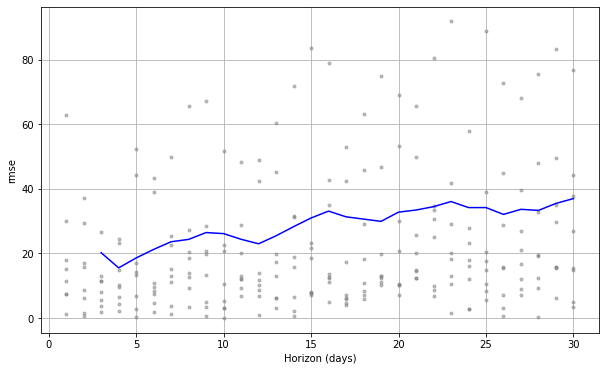

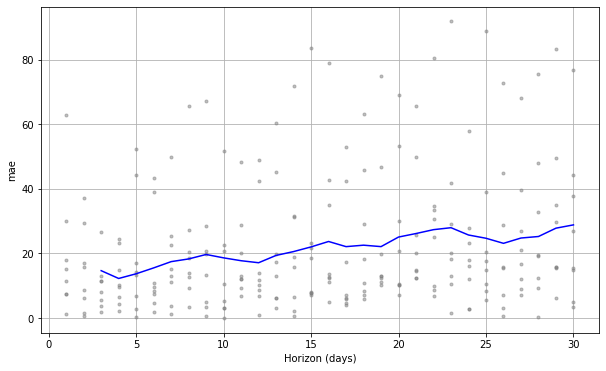

In [21]:
modelo.fit(df)
df_cv = cross_validation(modelo, initial='400 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
plot_cross_validation_metric(df_cv, metric='rmse');
plot_cross_validation_metric(df_cv, metric='mae');

## Otimizando Tendência

In [43]:
from sklearn.model_selection import ParameterGrid
params_grid = {'n_changepoints':[i for i in range(5, 85, 5)],
               'changepoint_prior_scale':[i/1000 for i in range(1, 500, 5)]}
grid = ParameterGrid(params_grid)

MAE = pd.DataFrame()
RMSE = pd.DataFrame()

for i in range(len(grid)):
  V1_modelo = Prophet(**grid[i])
  V1_modelo.fit(df)
  V1_df_cv = cross_validation(V1_modelo, initial='400 days', period='30 days', horizon='30 days')
  V1_df_p = performance_metrics(V1_df_cv)
  MAE[str(i)] = V1_df_p['mae']
  RMSE[str(i)] = V1_df_p['rmse']
  if i > 5:
    break

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


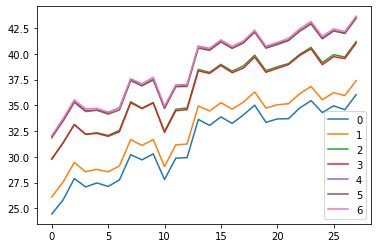

In [44]:
MAE.plot()